In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics.pairwise import cosine_distances
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

In [3]:
raw_data = '../data/winemag-data-190314.csv'

In [160]:
df = pd.read_csv(raw_data)

In [161]:
df.drop(labels='Unnamed: 0',axis=1,inplace=True)

In [162]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,vintage
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013.0
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011.0
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013.0
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013.0
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141617 entries, 0 to 141616
Data columns (total 14 columns):
country                  141556 non-null object
description              141617 non-null object
designation              101435 non-null object
points                   141617 non-null int64
price                    131959 non-null float64
province                 141556 non-null object
region_1                 118731 non-null object
region_2                 54785 non-null object
taster_name              116700 non-null object
taster_twitter_handle    110968 non-null object
title                    141617 non-null object
variety                  141616 non-null object
winery                   141617 non-null object
vintage                  136383 non-null float64
dtypes: float64(2), int64(1), object(11)
memory usage: 15.1+ MB


In [8]:
df.describe()

,points,price,vintage
count,141617.000000,131959.000000,136383.000000
mean,88.565561,36.247221,2011.264366
std,3.079296,45.981721,4.007991
min,80.000000,4.000000,1904.000000
25%,86.000000,17.000000,2009.000000
50%,88.000000,26.000000,2012.000000
75%,91.000000,44.000000,2014.000000
max,100.000000,5000.000000,2018.000000


## Country

In [9]:
country = df.groupby('country').count()['description']
country.reset_index
country.sort_values(ascending=False)

country
US                        58821
France                    25169
Italy                     21200
Spain                      7185
Portugal                   6160
Chile                      4683
Argentina                  3997
Austria                    3604
Australia                  2579
Germany                    2468
New Zealand                1556
South Africa               1489
Israel                      577
Greece                      470
Canada                      262
Bulgaria                    157
Hungary                     148
Uruguay                     112
Romania                     105
Turkey                       90
Moldova                      86
England                      85
Georgia                      84
Croatia                      83
Slovenia                     81
Mexico                       70
Brazil                       50
Lebanon                      32
Morocco                      24
Switzerland                  17
Peru                         16


In [88]:
points = df.groupby('points').count()['description']
#points.sort_values(ascending=False)

In [89]:
points

points
80       411
81       735
82      1936
83      3206
84      6697
85     10092
86     13190
87     17829
88     18408
89     13572
90     16885
91     12662
92     10787
93      7555
94      4441
95      1964
96       732
97       318
98       119
99        44
100       34
Name: description, dtype: int64

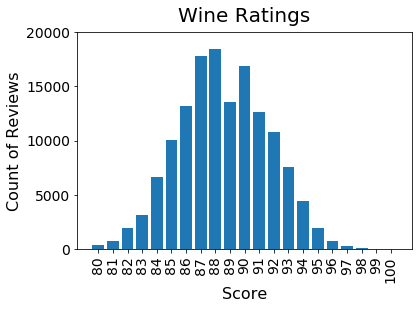

In [101]:
fig, ax = plt.subplots()
xvals = list(points.index)
yvals = points.values
plt.xticks(rotation='vertical',fontsize=14)
ax.bar(xvals,yvals)
ax.tick_params(axis="y", labelsize=14)
ax.set_xticks(xvals)
y_ticks = np.linspace(0,20000,5)
ax.set_yticks(y_ticks)
ax.set_xlabel("Score",fontsize=16)
ax.set_ylabel("Count of Reviews",fontsize=16)
ax.set_title("Wine Ratings",fontsize=20,pad=10);

## Variety

In [104]:
variety = df.groupby('variety').count()['description']
variety = variety.sort_values(ascending=False)

In [105]:
top_15_variety = variety[:15]
top_15_variety

variety
Pinot Noir                  14695
Chardonnay                  12546
Cabernet Sauvignon          10107
Red Blend                    9635
Bordeaux-style Red Blend     7878
Riesling                     5588
Sauvignon Blanc              5407
Syrah                        4357
Rosé                         4061
Nebbiolo                     3277
Merlot                       3230
Sangiovese                   2957
Zinfandel                    2907
Malbec                       2863
Portuguese Red               2671
Name: description, dtype: int64

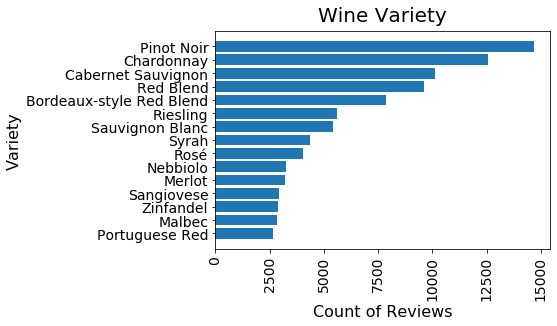

In [115]:
fig, ax = plt.subplots()
yvals = list(top_15_variety.index)
xvals = top_15_variety.values
plt.xticks(rotation='vertical',fontsize=14)
ax.barh(yvals,xvals)
ax.tick_params(axis="y", labelsize=14)
ax.set_yticks(yvals)
x_ticks = np.linspace(0,15000,7)
ax.set_xticks(x_ticks)
ax.set_ylabel("Variety",fontsize=16)
ax.set_xlabel("Count of Reviews",fontsize=16)
ax.set_title("Wine Variety",fontsize=20,pad=10)
ax.invert_yaxis();

## Vintage

In [119]:
vintage = df.groupby('vintage').count()['description']
#vintage.sort_values(ascending=False)

In [120]:
vintage

vintage
1904.0        1
1907.0        1
1912.0        7
1919.0        1
1927.0        2
1929.0        8
1931.0        1
1934.0        1
1935.0        1
1939.0        2
1941.0        1
1945.0        1
1947.0        1
1952.0        2
1954.0        1
1957.0        2
1961.0        1
1963.0        3
1964.0        2
1965.0        1
1966.0        2
1967.0        1
1968.0        2
1969.0        1
1973.0        1
1974.0        1
1976.0        1
1977.0        1
1978.0        2
1980.0        2
          ...  
1989.0        7
1990.0        5
1991.0        5
1992.0       16
1993.0        3
1994.0       23
1995.0       54
1996.0       68
1997.0      303
1998.0      551
1999.0      642
2000.0      756
2001.0      687
2002.0      361
2003.0      576
2004.0     1725
2005.0     3498
2006.0     5580
2007.0     6760
2008.0     7070
2009.0     9337
2010.0    11392
2011.0    11746
2012.0    14854
2013.0    15671
2014.0    16725
2015.0    14741
2016.0     9609
2017.0     3534
2018.0        6
Name: descriptio

In [154]:
years = list(vintage.index[44:])
[str(val)[:-2] for val in years]

['1996',
 '1997',
 '1998',
 '1999',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018']

In [155]:
yvals

array([   68,   303,   551,   642,   756,   687,   361,   576,  1725,
        3498,  5580,  6760,  7070,  9337, 11392, 11746, 14854, 15671,
       16725, 14741,  9609,  3534,     6])

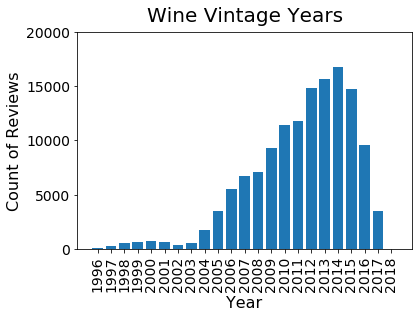

In [156]:
years = list(vintage.index[44:])
fig, ax = plt.subplots()
xvals = [str(val)[:-2] for val in years]
yvals = vintage.values[44:]
plt.xticks(rotation='vertical',fontsize=14)
ax.bar(xvals,yvals)
ax.tick_params(axis="y", labelsize=14)
ax.set_xticks(xvals)
#x_ticks = np.linspace(1996,2017,6)
y_ticks = np.linspace(0,20000,5)
#ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.set_xlabel("Year",fontsize=16)
ax.set_ylabel("Count of Reviews",fontsize=16)
ax.set_title("Wine Vintage Years",fontsize=20,pad=10);

## Price vs Score

In [171]:
df_cleaned = df[['price','points']]

In [172]:
df_cleaned = df_cleaned.dropna()

In [173]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131959 entries, 1 to 141616
Data columns (total 2 columns):
price     131959 non-null float64
points    131959 non-null int64
dtypes: float64(1), int64(1)
memory usage: 3.0 MB


In [176]:
df_cleaned = df_cleaned.sort_values(by='points', ascending=True)

In [177]:
df_cleaned.head()

,price,points
48224,10.0,80
41182,19.0,80
39031,19.0,80
48225,12.0,80
118557,14.0,80


In [ ]:
figsize=(10, 6)

In [181]:
df_pricepoints = df_cleaned.groupby('points').median()

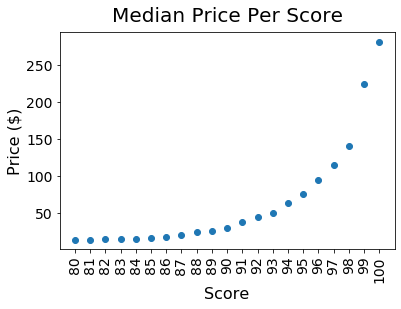

In [186]:
fig, ax = plt.subplots()
xvals = df_pricepoints.index
yvals = df_pricepoints.values
ax.scatter(xvals,yvals)
ax.tick_params(axis="y", labelsize=14)
plt.xticks(rotation='vertical',fontsize=14)
ax.set_xticks(xvals)
#y_ticks = np.linspace(0,20000,5)
#ax.set_yticks(y_ticks)
ax.set_xlabel("Score",fontsize=16)
ax.set_ylabel("Price ($)",fontsize=16)
ax.set_title("Median Price Per Score",fontsize=20,pad=10);

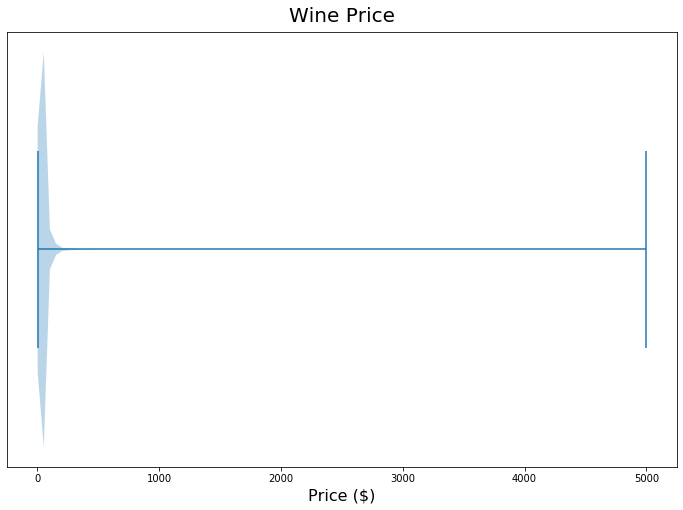

In [195]:
fig, ax = plt.subplots(figsize=(12,8))
ax.violinplot(df_cleaned.price, vert=False)
#ax.set_xlabel("Score",fontsize=16)
ax.set_xlabel("Price ($)",fontsize=16)
plt.tick_params(
    axis='y',         
    left=False,
    labelleft=False)
ax.set_title("Wine Price",fontsize=20,pad=10);

## Taster

In [15]:
taster = df.groupby('taster_twitter_handle').count()['description']
taster.sort_values(ascending=False)

taster_twitter_handle
@vossroger          28010
@wineschach         16084
@kerinokeefe        12724
@vboone             10844
@paulgwine          10153
@mattkettmann        7625
@wawinereport        5633
@gordone_cellars     5151
@JoeCz               4766
@AnneInVino          4456
@laurbuzz            2004
@worldwineguys       1152
@suskostrzewa        1061
@winewchristina       666
@apatrone23           471
@bkfiona              168
Name: description, dtype: int64

In [16]:
taster = df.groupby('taster_name').count()['description']
taster.sort_values(ascending=False)

taster_name
Roger Voss            28010
Michael Schachner     16084
Kerin O’Keefe         12724
Virginie Boone        10844
Paul Gregutt          10153
Matt Kettmann          7625
Sean P. Sullivan       5633
Jim Gordon             5151
Anna Lee C. Iijima     5075
Joe Czerwinski         4766
Anne Krebiehl MW       4456
Lauren Buzzeo          2004
Susan Kostrzewa        1061
Alexander Peartree      854
Christina Pickard       666
Mike DeSimone           595
Jeff Jenssen            557
Carrie Dykes            274
Fiona Adams             168
Name: description, dtype: int64

## Analyzing Description

In [17]:
df_desc = df.description

In [21]:
df_desc.head()

0    Aromas include tropical fruit, broom, brimston...
1    This is ripe and fruity, a wine that is smooth...
2    Tart and snappy, the flavors of lime flesh and...
3    Pineapple rind, lemon pith and orange blossom ...
4    Much like the regular bottling from 2012, this...
Name: description, dtype: object

In [22]:
df_desc = df_desc.str.lower()
df_desc = df_desc.str.replace('[^a-zA-Z0-9 \n\.]', ' ')
df_desc = df_desc.str.replace('\d', ' ')
df_desc = df_desc.str.replace('.', ' ')

In [23]:
df_desc.loc[1]

'this is ripe and fruity  a wine that is smooth while still structured  firm tannins are filled out with juicy red berry fruits and freshened with acidity  it s  already drinkable  although it will certainly be better from      '

In [24]:
df_desc[0]

'aromas include tropical fruit  broom  brimstone and dried herb  the palate isn t overly expressive  offering unripened apple  citrus and dried sage alongside brisk acidity '

## Stemming / Tokenization

In [25]:
desc = df_desc

In [26]:
desc

0         aromas include tropical fruit  broom  brimston...
1         this is ripe and fruity  a wine that is smooth...
2         tart and snappy  the flavors of lime flesh and...
3         pineapple rind  lemon pith and orange blossom ...
4         much like the regular bottling from       this...
5         blackberry and raspberry aromas show a typical...
6         here s a bright  informal red that opens with ...
7         this dry and restrained wine offers spice in p...
8         savory dried thyme notes accent sunnier flavor...
9         this has great depth of flavor with its fresh ...
10        soft  supple plum envelopes an oaky structure ...
11        this is a dry wine  very spicy  with a tight  ...
12        slightly reduced  this wine offers a chalky  t...
13        this is dominated by oak and oak driven aromas...
14        building on     years and six generations of w...
15        zesty orange peels and apple notes abound in t...
16        baked plum  molasses  balsamic

In [27]:
tokenized = [word_tokenize(content.lower()) for content in desc]

KeyboardInterrupt: 

In [ ]:
tokenized

In [ ]:
stop = set(stopwords.words('english'))
docs = [[word for word in words if word not in stop]
        for words in tokenized]

In [39]:
porter = PorterStemmer()
snowball = SnowballStemmer('english')
wordnet = WordNetLemmatizer()

In [ ]:
docs_porter = [[porter.stem(word) for word in words]
                for words in docs]
docs_snowball = [[snowball.stem(word) for word in words]
                for words in docs]
docs_wordnet = [[wordnet.lemmatize(word) for word in words]
                for words in docs]

In [ ]:
docs_porter

In [ ]:
print("{0}\t{1}\t{2}\t{3}".format("word", "porter", "snowball", "lemmatizer"))
print("-" * 20)
for i in range(min(len(docs_porter[0]), len(docs_snowball[0]), len(docs_wordnet[0]))):
    p, s, w = docs_porter[0][i], docs_snowball[0][i], docs_wordnet[0][i]
    if len(set((p, s, w))) != 1:
        print("{0}\t{1}\t{2}\t{3}".format(docs[0][i], p, s, w))

In [31]:
def tokenize(doc):
    '''
    INPUT: string
    OUTPUT: list of strings

    Tokenize and stem/lemmatize the document.
    '''
    return [wordnet.lemmatize(word) for word in word_tokenize(doc.lower())]

In [71]:
from sklearn.feature_extraction import stop_words
stop = list(stop_words.ENGLISH_STOP_WORDS)
additional_stop = ['ha', 'le', 'u', 'wa','s','t','s','r','ro','wine','flavor','aromas','finish', 'palate', 'note', 'nose', 'drink', 'ofcut', 'feeeling']
for val in additional_stop:
    stop.append(val)
stop = frozenset(stop)

In [72]:
stop

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'aromas',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',

In [49]:
countvect = CountVectorizer(stop_words=stop, tokenizer=tokenize)
count_vectorized = countvect.fit_transform(desc)

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aroma'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [41]:
words = countvect.get_feature_names()

In [42]:
words

['aa',
 'aacacia',
 'aand',
 'aarde',
 'aaron',
 'ab',
 'abacela',
 'abadal',
 'abadia',
 'abandon',
 'abandoned',
 'abate',
 'abbazia',
 'abbess',
 'abbey',
 'abboccato',
 'abbot',
 'abbott',
 'abbreviated',
 'abc',
 'abeille',
 'abeilles',
 'abeja',
 'abel',
 'abele',
 'abelis',
 'abernathy',
 'aberrant',
 'abetina',
 'abeyance',
 'abide',
 'abiding',
 'abilio',
 'ability',
 'abiouness',
 'able',
 'ably',
 'abnormal',
 'abnormally',
 'aboard',
 'abondante',
 'abord',
 'aboriginal',
 'abound',
 'abounding',
 'abounds',
 'abouriou',
 'abovde',
 'abraham',
 'abrasive',
 'abrasively',
 'abrasiveness',
 'abraxas',
 'abrazo',
 'abreu',
 'abrie',
 'abrigo',
 'abroad',
 'abrupt',
 'abruptly',
 'abruptness',
 'abruzzo',
 'absberg',
 'absence',
 'absense',
 'absent',
 'absinthe',
 'absolute',
 'absolutely',
 'absorb',
 'absorbed',
 'absorbing',
 'absorbingly',
 'absorbs',
 'absurd',
 'absurdly',
 'abtsberg',
 'abtsfronhof',
 'abundance',
 'abundant',
 'abundantly',
 'abupt',
 'abused',
 'abuts

In [43]:
lda = LatentDirichletAllocation(n_components=7, max_iter=5, learning_method='online',random_state=0, n_jobs=-1)
lda.fit(count_vectorized)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=7, n_jobs=-1,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [44]:
components = lda.components_

In [45]:
tf_feature_names = np.array(words)

In [46]:
def find_top_words(matrix):
    words = []
    for idx, __ in enumerate(matrix):
        top_words = np.argsort(matrix[idx])[-10:][::-1]
        top_words = tf_feature_names[top_words]
        words.append(top_words)
    return words

In [47]:
top_words_in_topic = find_top_words(components)
top_words_in_topic

[array(['flavor', 'aroma', 'finish', 'fruit', 'palate', 'berry', 'plum',
        'feel', 'herbal', 'note'], dtype='<U20'),
 array(['apple', 'palate', 'flavor', 'acidity', 'wine', 'citrus', 'lemon',
        'white', 'finish', 'fresh'], dtype='<U20'),
 array(['palate', 'aroma', 'black', 'cherry', 'tannin', 'spice', 'red',
        'offer', 'note', 'herb'], dtype='<U20'),
 array(['wine', 'fruit', 'drink', 'tannin', 'acidity', 'ripe', 'rich',
        'flavor', 'black', 'year'], dtype='<U20'),
 array(['flavor', 'cherry', 'wine', 'bodied', 'make', 'oak', 'sweet',
        'finish', 'raspberry', 'blackberry'], dtype='<U20'),
 array(['vineyard', 'bottling', 'new', 'oak', 'grape', 'vine', 'old',
        'estate', 'french', 'valley'], dtype='<U20'),
 array(['taste', 'cranberry', 'wine', 'big', 'blend', 'syrah', 'best',
        'fruit', 'chocolate', 'end'], dtype='<U20')]

In [ ]:
theta = lda.transform(count_vectorized)

In [ ]:
def find_similar_wines(wine_title):
    awine_idx = df[df['title'] == wine_title].index[0]
    dists = cosine_distances(theta, theta)
    top_wines = np.argsort(dists[wine_idx,:])[-10:][::1]
    top_wines = df.title[top_wines]
    return top_wines[1:]

In [ ]:
wine_title = 'Quinta dos Avidagos 2011 Avidagos Red (Douro)'

In [30]:
#find_similar_wines(wine_title)

## Testing NMF

In [74]:
tf_vect = TfidfVectorizer(stop_words=stop,tokenizer=tokenize)
tf = tf_vect.fit_transform(desc)

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aroma'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [84]:
nmf = NMF(n_components = 10)
nmf.fit(tf)
W = nmf.transform(tf)
H = nmf.components_
topic_words = find_top_words(H)

In [81]:
topic_words #4

[array(['black', 'cherry', 'tanins', 'aroma', 'alongside', 'berry',
        'oeuvre', 'recreates', 'spends', 'pepella'], dtype='<U20'),
 array(['apple', 'whispering', 'citrus', 'freres', 'lemelson', 'crisp',
        'acidity', 'pazzo', 'peachy', 'lifting'], dtype='<U20'),
 array(['fruchtig', 'ripan', 'acidity', 'ric', 'tanins', 'wonderful',
        'character', 'texbook', 'reactive', 'aging'], dtype='<U20'),
 array(['cabernet', 'nymph', 'blend', 'blackberry', 'sauteed', 'merited',
        'cherry', 'chocolate', 'plowbuster', 'sweaty'], dtype='<U20')]

In [79]:
topic_words #5

[array(['cherry', 'black', 'aroma', 'tanins', 'berry', 'alongside',
        'oeuvre', 'spends', 'plowbuster', 'pepella'], dtype='<U20'),
 array(['apple', 'whispering', 'lemelson', 'citrus', 'pazzo', 'peachy',
        'aroma', 'greco', 'lima', 'freres'], dtype='<U20'),
 array(['fruchtig', 'ripan', 'ric', 'tanins', 'wonderful', 'aging',
        'strove', 'black', 'yarrabank', 'age'], dtype='<U20'),
 array(['cabernet', 'blend', 'sauteed', 'merited', 'nymph', 'blackberry',
        'framework', 'synchronize', 'chocolate', 'cherry'], dtype='<U20'),
 array(['fruitiness', 'acidity', 'recreates', 'lifting', 'crisp',
        'socking', 'reactive', 'freres', 'bright', 'attractive'],
       dtype='<U20')]

In [77]:
topic_words #6

[array(['black', 'cherry', 'tanins', 'aroma', 'alongside', 'oeuvre',
        'pepella', 'berry', 'spends', 'recreates'], dtype='<U20'),
 array(['apple', 'whispering', 'lemelson', 'citrus', 'pazzo', 'peachy',
        'greco', 'lima', 'freres', 'aroma'], dtype='<U20'),
 array(['fruchtig', 'ripan', 'ric', 'tanins', 'wonderful', 'aging',
        'strove', 'black', 'age', 'firewood'], dtype='<U20'),
 array(['nymph', 'aroma', 'sweaty', 'plowbuster', 'cherry', 'feeding',
        'valued', 'blackberry', 'berry', 'herbacesously'], dtype='<U20'),
 array(['fruitiness', 'acidity', 'recreates', 'crisp', 'lifting',
        'socking', 'reactive', 'freres', 'attractive', 'bright'],
       dtype='<U20'),
 array(['cabernet', 'sauteed', 'blend', 'merited', 'framework', 'verdesca',
        'petal', 'synchronize', 'malagousia', 'currant'], dtype='<U20')]

In [83]:
topic_words #7

[array(['black', 'cherry', 'tanins', 'alongside', 'aroma', 'oeuvre',
        'pepella', 'spends', 'dried', 'lick'], dtype='<U20'),
 array(['apple', 'whispering', 'lemelson', 'citrus', 'pazzo', 'peachy',
        'aroma', 'lima', 'greco', 'yearold'], dtype='<U20'),
 array(['fruchtig', 'ripan', 'ric', 'tanins', 'wonderful', 'aging',
        'strove', 'black', 'firewood', 'age'], dtype='<U20'),
 array(['nymph', 'sweaty', 'cherry', 'valued', 'bodied', 'pinkish',
        'liguria', 'rasina', 'blackberry', 'drupeggio'], dtype='<U20'),
 array(['fruitiness', 'acidity', 'crisp', 'recreates', 'lifting',
        'socking', 'reactive', 'attractive', 'bright', 'freres'],
       dtype='<U20'),
 array(['cabernet', 'sauteed', 'blend', 'merited', 'framework', 'verdesca',
        'petal', 'synchronize', 'malagousia', 'currant'], dtype='<U20'),
 array(['berry', 'plowbuster', 'aroma', 'herbacesously', 'feeding',
        'fruchtig', 'recreates', 'earthshaking', 'greco', 'spicebox'],
       dtype='<U20')]

In [85]:
topic_words #10

[array(['alongside', 'tanins', 'oeuvre', 'aroma', 'cherry', 'spends',
        'berry', 'dried', 'recreates', 'clove'], dtype='<U20'),
 array(['apple', 'whispering', 'lemelson', 'citrus', 'pazzo', 'peachy',
        'lima', 'greco', 'freres', 'yearold'], dtype='<U20'),
 array(['fruchtig', 'ripan', 'ric', 'wonderful', 'tanins', 'aging',
        'strove', 'age', 'firewood', 'yarrabank'], dtype='<U20'),
 array(['nymph', 'sweaty', 'valued', 'tl', 'blackberry', 'neve', 'socking',
        'freindly', 'chardonnay', 'pinard'], dtype='<U20'),
 array(['fruitiness', 'acidity', 'crisp', 'socking', 'reactive', 'lifting',
        'recreates', 'attractive', 'bright', 'freres'], dtype='<U20'),
 array(['cabernet', 'sauteed', 'blend', 'merited', 'framework', 'verdesca',
        'petal', 'synchronize', 'malagousia', 'hepped'], dtype='<U20'),
 array(['berry', 'plowbuster', 'aroma', 'herbacesously', 'feeding',
        'fruchtig', 'earthshaking', 'greco', 'recreates', 'spicebox'],
       dtype='<U20'),
 array

## Using Gensim Pipeline

In [202]:
def lemmatize_stemming(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')

def preprocess(text):
    result = []
    for token in simple_preprocess(text):
        stem = lemmatize_stemming(token)
        if stem not in stop_words and len(stem) > 3:
            result.append(stem)
    return result

In [203]:
raw_data = '../data/winemag-data-190314.csv'
df = pd.read_csv(raw_data)
df.drop(labels='Unnamed: 0',axis=1,inplace=True)
desc = df.description
desc = desc.str.lower()
desc = desc.str.replace('[^a-zA-Z0-9 \n\.]', ' ')
desc = desc.str.replace('\d', ' ')
desc = desc.str.replace('.', ' ')

additional_stop = ['wine','flavor','aromas','finish', 'palate', 'note', 'nose', 'drink', 'fruit', 'like']
stop_words = list(STOPWORDS)
for val in additional_stop:
    stop_words.append(val)
stop_words = frozenset(stop_words)

processed_docs = desc.map(preprocess)

In [204]:
type(processed_docs)

pandas.core.series.Series

In [206]:
doc_lens = [len(doc) for doc in processed_docs]

In [216]:
len(processed_docs[0])

15

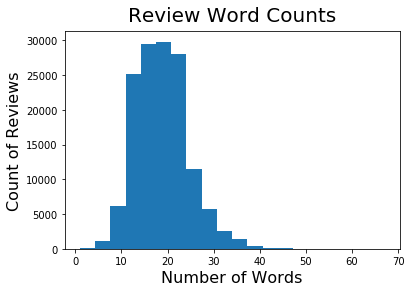

In [217]:
fig, ax = plt.subplots()
ax.hist(doc_lens, bins = 20)
ax.set_xlabel("Number of Words",fontsize=16)
ax.set_ylabel("Count of Reviews",fontsize=16)
ax.set_title("Review Word Counts",fontsize=20,pad=10);

In [256]:
wine_desc = pd.DataFrame(doc_lens,df.points,columns=['word_cnt'])

In [257]:
wine_desc.index

Int64Index([87, 87, 87, 87, 87, 87, 87, 87, 87, 87,
            ...
            92, 92, 92, 92, 92, 92, 92, 92, 92, 92],
           dtype='int64', name='points', length=141617)

In [258]:
wine_desc.reset_index(inplace=True)

In [259]:
wine_desc.head()

,points,word_cnt
0,87,15
1,87,13
2,87,15
3,87,16
4,87,19


In [260]:
wine_points_desc = wine_desc.groupby('points').median()

In [261]:
wine_points_desc

,word_cnt
points,
80,11
81,12
82,12
83,14
84,14
85,15
86,16
87,17
88,18


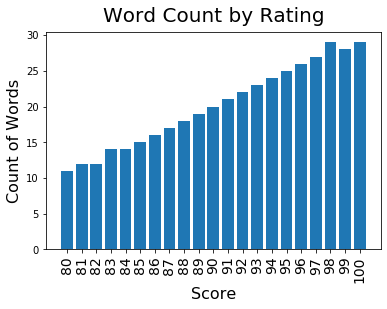

In [268]:
fig, ax = plt.subplots()
xvals = wine_points_desc.index
yvals = wine_points_desc.word_cnt
plt.xticks(rotation='vertical',fontsize=14)
ax.bar(xvals,yvals)
#ax.tick_params(axis="y", labelsize=14)
ax.set_xticks(xvals)
#y_ticks = np.linspace(0,20000,5)
#ax.set_yticks(y_ticks)
ax.set_xlabel("Score",fontsize=16)
ax.set_ylabel("Count of Words",fontsize=16)
ax.set_title("Word Count by Rating",fontsize=20,pad=10);

## Wordcloud

In [ ]:
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate()

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()